In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon/Sample_Submission.csv
/kaggle/input/amazon/train.csv
/kaggle/input/amazon/test.csv
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt


Importing all the necessary packages 

In [7]:
import os
import numpy as np
import pandas as pd
import re
import string
from string import digits
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Embedding, SimpleRNN, LSTM, Dropout, Activation, Concatenate
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt


Importing and preparing data 

In [8]:
train_data = pd.read_csv("/kaggle/input/amazon/train.csv")


train_title_X = train_data.loc[:,'Review Title']
train_title_X = [x.lower() for x in train_title_X]
#train_title_X = [re.sub("'", '', x) for x in train_title_X]
train_text_X = train_data.loc[:,'Review Text']
train_text_X = [x.lower() for x in train_text_X]
#train_text_X = [re.sub("'", '', x) for x in train_text_X]
train_y = train_data['topic']
train_y = pd.get_dummies(train_y)

t = Tokenizer()
t.fit_on_texts(train_title_X)
title_vocab_size = len(t.word_index) + 1
    
encoded_train_title_X = t.texts_to_sequences(train_title_X)
    
word_title_index = t.word_index

t.fit_on_texts(train_text_X)
text_vocab_size = len(t.word_index) + 1

encoded_train_text_X = t.texts_to_sequences(train_text_X)

word_text_index = t.word_index


max_title_length = max([len(x) for x in encoded_train_title_X])
padded_train_title_X = pad_sequences(encoded_train_title_X, maxlen=max_title_length, padding='post')

max_text_length = max([len(x) for x in encoded_train_text_X])
padded_train_text_X = pad_sequences(encoded_train_text_X, maxlen=max_text_length, padding='post')
    
    
embeddings_index = dict()
words = []
f = open('/kaggle/input/glove6b/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    words.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    	
f.close()
#print('Loaded %s word vectors.' % len(embeddings_index))
    
embedding_title_matrix = np.zeros((title_vocab_size, 100))
for word, i in word_title_index.items():
   embedding_vector = embeddings_index.get(word)
   if embedding_vector is not None:
       embedding_title_matrix[i] = embedding_vector
       
embedding_text_matrix = np.zeros((text_vocab_size, 100))
for word, i in word_text_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_text_matrix[i] = embedding_vector

Defining the model

In [25]:
sentences_title = Input((max_title_length,), dtype='int32')
embeddings_title = Embedding(title_vocab_size, 100, weights=[embedding_title_matrix], input_length=max_title_length, trainable=False)(sentences_title)
X = LSTM(128, return_sequences=False)(embeddings_title)
X = Dropout(0.2)(X)
#X = Activation('softmax')(X)

sentences_text = Input((max_text_length,), dtype='int32')
embeddings_text = Embedding(text_vocab_size, 100, weights=[embedding_text_matrix], input_length=max_text_length, trainable=False)(sentences_text)
X2 = LSTM(128, return_sequences=True)(embeddings_text)
X2 = LSTM(128, return_sequences=False)(X2)
X2 = Dropout(0.2)(X)
X3 = Concatenate()([X,X2])
X3 = Dense(21)(X2)
output = Activation('softmax')(X3)
    
model = Model(inputs=[sentences_title,sentences_text], outputs=output)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 20, 100)           258800    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 21)                2709      
_________________________________________________________________
activation_7 (Activation)    (None, 21)                0   

Compiling and training

Optimizer :<keras.optimizers.Adam object at 0x7f0b3073c7b8>
Train on 4171 samples, validate on 1788 samples
Epoch 1/50
4171/4171 [==============================] - 5s 1ms/step - loss: 2.6040 - accuracy: 0.2103 - val_loss: 2.4070 - val_accuracy: 0.2472
Epoch 2/50
4171/4171 [==============================] - 4s 899us/step - loss: 2.3588 - accuracy: 0.2700 - val_loss: 2.2771 - val_accuracy: 0.3082
Epoch 3/50
4171/4171 [==============================] - 4s 855us/step - loss: 2.2641 - accuracy: 0.3225 - val_loss: 2.2081 - val_accuracy: 0.3238
Epoch 4/50
4171/4171 [==============================] - 3s 807us/step - loss: 2.1788 - accuracy: 0.3553 - val_loss: 2.1529 - val_accuracy: 0.3574
Epoch 5/50
4171/4171 [==============================] - 4s 863us/step - loss: 2.1181 - accuracy: 0.3728 - val_loss: 2.1605 - val_accuracy: 0.3596
Epoch 6/50
4171/4171 [==============================] - 3s 813us/step - loss: 2.0668 - accuracy: 0.3963 - val_loss: 2.0963 - val_accuracy: 0.3786
Epoch 7/50
4171/41

Text(0.5, 0, 'accuracy')

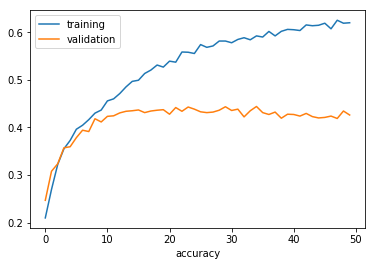

In [26]:
epochs=50
lr=.001
decay = lr/epochs
adam = Adam(lr=lr, beta_1=.9, beta_2=.999, decay=decay)
sgd = SGD(lr=.001)
rmsprop = RMSprop(lr=.001)
optimizer = adam

print('Optimizer :'+str(optimizer))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit([padded_train_title_X,padded_train_text_X] , train_y, validation_split=0.3, epochs=epochs, verbose=1, batch_size=32)
plt.figure()
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.xlabel('accuracy')
    

In [17]:
padded_train_title_X.shape

(5959, 20)

In [18]:
padded_train_text_X.shape

(5959, 551)

In [24]:
train_y.shape

(5959, 21)